In [173]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nibabel as nib
import tensorflow as tf
import sklearn
from sklearn.metrics import roc_curve, auc
import scipy
from scipy.stats import wilcoxon

In [84]:
k=15
#img_path ='C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(k,k,k)
img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(k,k,k)
img = nib.load(img_path)
img_data = img.get_fdata()
print(img_data.shape[2])
img= img_data[:,:,12]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
#plt.imshow(img,cmap='gray')
#fig=plt.gcf()
#plt.axis('off')
#fig.savefig('hypofig',bbox_inches='tight')

40


In [174]:
#choose negative and positive slices from the 1st data set

posPatients = np.concatenate((np.array([2,4,5,7,9,11,12,13,16,17,18,19,21,22]),range(23,109)))
locList = []
img_height = 128

#find locations of the positive slices from the binary masks
for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    for j in range(img_data.shape[2]):
        slice = img_data[:,:,j]
        if np.max(slice)>0:
            locations.append(j)
    locList.append(np.array(locations))

posList = []

#choose positive slices from the given locations
for i in range(len(posPatients)):
    if posPatients[i]<23:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(cv2.resize(img_data[:,:,locList[i][j]],(img_height,img_height)))
    posList.append(pos)

negPatients = np.concatenate((np.array([1,2,4,6,10,11,12,14,15,16,18,22,23,24,25,26,28,31,33,34,36,38,39,41,43,44,45,47,48]),
                              range(51,63),range(64,123)))
negList = []

#choose random negative slices
for i in range(len(negPatients)):
    if negPatients[i]<49:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    else:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    neg = []
    if i<15:
        number=12
    else:
        number=11
    indexes=np.random.choice(range(img_data.shape[2]),size=number,replace=False)
    maxValues=[]
    for j in range(number):
        maxValues.append(np.max(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height))))
    while(np.min(maxValues)==0):
        indexes=np.random.choice(range(img_data.shape[2]),size=number,replace=False)
        maxValues=[]
        for j in range(number):
            maxValues.append(np.max(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height))))
    for j in range(number):
        neg.append(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height)))
    negList.append(neg)

In [171]:
#check number of slices in the original pet images

numberOfSlices=[]

for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    numberOfSlices.append(img_data.shape[2])

for i in range(len(negPatients)):
    if negPatients[i]<49:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    else:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    numberOfSlices.append(img_data.shape[2])

print(min(numberOfSlices[0:99]))
print(max(numberOfSlices[0:99]))
print(min(numberOfSlices[100:199]))
print(max(numberOfSlices[100:199]))

32
66
32
48


In [175]:
#convert images into typical format

def convert(img):

    img=(img-np.min(img))/(np.max(img)-np.min(img))*255
    for i in range(128):
        for j in range(128):
            img[i,j]=int(img[i,j])
    return img.astype('int64')

for i in range(len(posList)):
    for j in range(len(posList[i])):
        posList[i][j]=convert(posList[i][j])

for i in range(len(negList)):
    for j in range(len(negList[i])):
        negList[i][j]=convert(negList[i][j])

In [52]:
#check the number of chosen slices
numberOfSlices=[]
for i in range(len(posList)):
    numberOfSlices.append(len(posList[i]))
print(len(posList))
print(min(numberOfSlices))
print(max(numberOfSlices))
print(sum(numberOfSlices))
print(sum(numberOfSlices)/5)

100
2
28
1115
223.0


In [176]:
#choose testSetIndexes

testSetPos1=np.concatenate((range(0,85,5),np.array([86,90,99])))
testSetPos2=np.concatenate((range(1,85,5),np.array([92,93,94,95,97])))
testSetPos3=np.concatenate((range(2,85,5),np.array([96,98])))
testSetPos4=np.concatenate((range(3,85,5),np.array([87,88,89])))
testSetPos5=np.concatenate((range(4,85,5),np.array([85,91])))

testSetNeg1=np.array(range(0,100,5))
testSetNeg2=np.array(range(1,100,5))
testSetNeg3=np.array(range(2,100,5))
testSetNeg4=np.array(range(3,100,5))
testSetNeg5=np.array(range(4,100,5))

numberOfSlices=np.zeros((10))
testSetIndexes=[testSetPos1,testSetPos2,testSetPos3,testSetPos4,testSetPos5,testSetNeg1,testSetNeg2,testSetNeg3,testSetNeg4,testSetNeg5]
for j in range(5):
    for i in range(len(posList)):
        if i in testSetIndexes[j]:
            numberOfSlices[j]+=len(posList[i])
for j in range(5,10):
    for i in range(len(negList)):
        if i in testSetIndexes[j]:
            numberOfSlices[j]+=len(negList[i])

print(numberOfSlices)

[223. 223. 223. 223. 223. 223. 223. 223. 223. 223.]


In [177]:
def divideIntoSets_hnc(posList,negList,testSetIndexes,k):

    testSetPos=[]
    trainSetPos=[]
    for i in range(len(posList)):
        if i in testSetIndexes[k-1]:
            for j in range(len(posList[i])):
                testSetPos.append(posList[i][j])
        else:
            for j in range(len(posList[i])):
                trainSetPos.append(posList[i][j])

    testSetNeg=[]
    trainSetNeg=[]
    for i in range(len(negList)):
        if i in testSetIndexes[4+k]:
            for j in range(len(negList[i])):
                testSetNeg.append(negList[i][j])
        else:
            for j in range(len(negList[i])):
                trainSetNeg.append(negList[i][j])

    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]

    for i in range(len(testSetPos)):
        x_test.append(testSetNeg[i])
        y_test.append(0)
        x_test.append(testSetPos[i])
        y_test.append(1)

    for i in range(len(trainSetPos)):
        x_train.append(trainSetNeg[i])
        y_train.append(0)
        x_train.append(trainSetPos[i])
        y_train.append(1) 

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)

    return([x_train,y_train,x_test,y_test])

In [148]:
x_train,y_train,x_test,y_test=divideIntoSets_hnc(posList,negList,testSetIndexes,1)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

1784
1784
446
446


In [34]:
filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/br35h/no/')
filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/br35h/yes/')
img_height = 128

brhImgs=[]

for i in range(1500):
    img_path='C:/Users/Oona/Documents/Tpc/thr/br35h/no/{}'.format(filenames[i])
    img=cv2.imread(img_path)
    img=cv2.resize(img[:,:,0],(img_height,img_height))
    brhImgs.append(img)
    img_path1='C:/Users/Oona/Documents/Tpc/thr/br35h/yes/{}'.format(filenames1[i])
    img1=cv2.imread(img_path1)
    img1=cv2.resize(img1[:,:,0],(img_height,img_height))
    brhImgs.append(img1)

In [32]:
filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/covid/normal/')
filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/covid/cvd')
img_height = 128

cvdImgs=[]

for i in range(3000):
    img_path='C:/Users/Oona/Documents/Tpc/thr/covid/normal/{}'.format(filenames[i])
    img=cv2.imread(img_path)
    img=cv2.resize(img[:,:,0],(img_height,img_height))
    cvdImgs.append(img)
    img_path1='C:/Users/Oona/Documents/Tpc/thr/covid/cvd/{}'.format(filenames1[i])
    img1=cv2.imread(img_path1)
    img1=cv2.resize(img1[:,:,0],(img_height,img_height))
    cvdImgs.append(img1)

In [11]:
import os
file_path='C:/Users/Oona/Downloads/pneu/'
files=os.listdir(file_path)
print(files[0][0:10])
for i in range(len(files)-1):
    #if files[i][0:10]==files[i+1][0:10]:
    #    pneu_path='C:/Users/Oona/Downloads/pneu/{}'.format(files[i+1])
    #    os.remove(pneu_path)
    if i>1580:
        pneu_path='C:/Users/Oona/Downloads/pneu/{}'.format(files[i])
        os.remove(pneu_path)

person1000


In [28]:
filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/pneumonia/normal')
filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/pneumonia/ill')
img_height = 128

pneuImgs=[]

for i in range(1580):
    img_path='C:/Users/Oona/Documents/Tpc/thr/pneumonia/normal/{}'.format(filenames[i])
    img=cv2.imread(img_path)
    img=cv2.resize(img[:,:,0],(img_height,img_height))
    pneuImgs.append(img)
    img_path1='C:/Users/Oona/Documents/Tpc/thr/pneumonia/ill/{}'.format(filenames1[i])
    img1=cv2.imread(img_path1)
    img1=cv2.resize(img1[:,:,0],(img_height,img_height))
    pneuImgs.append(img1)

In [17]:
filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/tuberculosis/normal')
filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/tuberculosis/tb')
img_height = 128

tbImgs=[]

for i in range(700):
    img_path='C:/Users/Oona/Documents/Tpc/thr/tuberculosis/normal/{}'.format(filenames[i])
    img=cv2.imread(img_path)
    img=cv2.resize(img[:,:,0],(img_height,img_height))
    tbImgs.append(img)
    img_path1='C:/Users/Oona/Documents/Tpc/thr/tuberculosis/tb/{}'.format(filenames1[i])
    img1=cv2.imread(img_path1)
    img1=cv2.resize(img1[:,:,0],(img_height,img_height))
    tbImgs.append(img1)

In [29]:
def divideImgsIntoSets(Imgs,k):

    numberOfImgs=len(Imgs)
    testSetSize=int(numberOfImgs/5)
    trainSetSize=numberOfImgs-testSetSize
    x_train=np.array(Imgs[0:((k-1)*testSetSize)]+Imgs[(k*testSetSize):numberOfImgs])
    y_train=np.array([0,1]*int(trainSetSize/2))
    x_test=np.array(Imgs[((k-1)*testSetSize):(k*testSetSize)])
    y_test=np.array([0,1]*int(testSetSize/2))

    return([x_train,y_train,x_test,y_test])

In [30]:
x_train,y_train,x_test,y_test=divideImgsIntoSets(pneuImgs,1)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2528
2528
632
632


In [178]:
def predict(x_train,y_train,x_test,numEpochs):

    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(img_height,img_height,1)),
                                    tf.keras.layers.Conv2D(16, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.Conv2D(128, 3, activation='relu'),
                                    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
    ] 
    )

    model.compile(
        optimizer=tf.keras.optimizers.SGD(1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        mode='min', patience=15, restore_best_weights=True)

    model.fit(x=x_train,y=y_train,epochs=numEpochs,validation_split=0.3,callbacks=[earlystopping],shuffle=True)
    predictions=model.predict(x_test)
    trainPreds=model.predict(x_train)

    return([predictions,trainPreds])

In [179]:
for k in range(1,6):
    x_train,y_train,x_test,y_test=divideIntoSets_hnc(posList,negList,testSetIndexes,k)
    #print(len(x_test))
    predictions,trainPreds=predict(x_train,y_train,x_test,10)
    np.savetxt('thr_hnc_{}_trainPreds.txt'.format(k),trainPreds)
    np.savetxt('thr_hnc_{}_predictions.txt'.format(k),predictions)

Epoch 1/10
39/39 [==============================] - 40s 976ms/step - loss: 0.6412 - binary_accuracy: 0.6603 - val_loss: 0.6130 - val_binary_accuracy: 0.6828
Epoch 2/10
39/39 [==============================] - 33s 847ms/step - loss: 0.5420 - binary_accuracy: 0.7268 - val_loss: 0.7059 - val_binary_accuracy: 0.5746
Epoch 3/10
39/39 [==============================] - 36s 925ms/step - loss: 0.4928 - binary_accuracy: 0.7676 - val_loss: 0.5897 - val_binary_accuracy: 0.6978
Epoch 4/10
39/39 [==============================] - 33s 840ms/step - loss: 0.4699 - binary_accuracy: 0.7788 - val_loss: 0.5836 - val_binary_accuracy: 0.7034
Epoch 5/10
39/39 [==============================] - 33s 853ms/step - loss: 0.4727 - binary_accuracy: 0.7812 - val_loss: 0.6624 - val_binary_accuracy: 0.6231
Epoch 6/10
39/39 [==============================] - 31s 798ms/step - loss: 0.4393 - binary_accuracy: 0.8053 - val_loss: 0.6980 - val_binary_accuracy: 0.6082
Epoch 7/10
39/39 [==============================] - 31s 79

In [37]:
for k in range(1,6):
    x_train,y_train,x_test,y_test=divideImgsIntoSets(brhImgs,k)
    predictions,trainPreds=predict(x_train,y_train,x_test,15)
    np.savetxt('thr_brh_{}_trainPreds.txt'.format(k),trainPreds)
    np.savetxt('thr_brh_{}_predictions.txt'.format(k),predictions)

Epoch 1/15
53/53 [==============================] - 49s 903ms/step - loss: 0.6660 - binary_accuracy: 0.6530 - val_loss: 0.7541 - val_binary_accuracy: 0.5403
Epoch 2/15
53/53 [==============================] - 46s 866ms/step - loss: 0.5318 - binary_accuracy: 0.7423 - val_loss: 0.5206 - val_binary_accuracy: 0.7833
Epoch 3/15
53/53 [==============================] - 44s 840ms/step - loss: 0.4816 - binary_accuracy: 0.7827 - val_loss: 0.7941 - val_binary_accuracy: 0.5083
Epoch 4/15
53/53 [==============================] - 45s 852ms/step - loss: 0.4687 - binary_accuracy: 0.7845 - val_loss: 0.4575 - val_binary_accuracy: 0.7986
Epoch 5/15
53/53 [==============================] - 45s 858ms/step - loss: 0.4126 - binary_accuracy: 0.8143 - val_loss: 0.4087 - val_binary_accuracy: 0.8417
Epoch 6/15
53/53 [==============================] - 44s 823ms/step - loss: 0.3865 - binary_accuracy: 0.8250 - val_loss: 0.6938 - val_binary_accuracy: 0.6653
Epoch 7/15
53/53 [==============================] - 45s 84

In [33]:
for k in range(1,6):
    x_train,y_train,x_test,y_test=divideImgsIntoSets(cvdImgs,k)
    predictions,trainPreds=predict(x_train,y_train,x_test,10)
    np.savetxt('thr_cvd_{}_trainPreds.txt'.format(k),trainPreds)
    np.savetxt('thr_cvd_{}_predictions.txt'.format(k),predictions)

Epoch 1/10
105/105 [==============================] - 87s 822ms/step - loss: 0.6325 - binary_accuracy: 0.6610 - val_loss: 0.4701 - val_binary_accuracy: 0.8792
Epoch 2/10
105/105 [==============================] - 84s 798ms/step - loss: 0.5494 - binary_accuracy: 0.7271 - val_loss: 0.3916 - val_binary_accuracy: 0.8972
Epoch 3/10
105/105 [==============================] - 86s 824ms/step - loss: 0.4923 - binary_accuracy: 0.7616 - val_loss: 0.3293 - val_binary_accuracy: 0.8722
Epoch 4/10
105/105 [==============================] - 93s 889ms/step - loss: 0.4672 - binary_accuracy: 0.7768 - val_loss: 0.2547 - val_binary_accuracy: 0.9375
Epoch 5/10
105/105 [==============================] - 95s 907ms/step - loss: 0.4484 - binary_accuracy: 0.7807 - val_loss: 0.2398 - val_binary_accuracy: 0.9354
Epoch 6/10
105/105 [==============================] - 91s 870ms/step - loss: 0.4351 - binary_accuracy: 0.7896 - val_loss: 0.2140 - val_binary_accuracy: 0.9465
Epoch 7/10
105/105 [==========================

In [31]:
for k in range(1,6):
    x_train,y_train,x_test,y_test=divideImgsIntoSets(pneuImgs,k)
    predictions,trainPreds=predict(x_train,y_train,x_test,10)
    np.savetxt('thr_pneu_{}_trainPreds.txt'.format(k),trainPreds)
    np.savetxt('thr_pneu_{}_predictions.txt'.format(k),predictions)

Epoch 1/10
56/56 [==============================] - 51s 883ms/step - loss: 0.6310 - binary_accuracy: 0.6450 - val_loss: 0.5761 - val_binary_accuracy: 0.6640
Epoch 2/10
56/56 [==============================] - 45s 809ms/step - loss: 0.5237 - binary_accuracy: 0.7535 - val_loss: 0.5930 - val_binary_accuracy: 0.6192
Epoch 3/10
56/56 [==============================] - 45s 808ms/step - loss: 0.4493 - binary_accuracy: 0.7937 - val_loss: 0.3406 - val_binary_accuracy: 0.8801
Epoch 4/10
56/56 [==============================] - 44s 795ms/step - loss: 0.4148 - binary_accuracy: 0.8135 - val_loss: 0.4583 - val_binary_accuracy: 0.7721
Epoch 5/10
56/56 [==============================] - 50s 898ms/step - loss: 0.3590 - binary_accuracy: 0.8361 - val_loss: 0.3339 - val_binary_accuracy: 0.8656
Epoch 6/10
56/56 [==============================] - 46s 824ms/step - loss: 0.3216 - binary_accuracy: 0.8626 - val_loss: 0.3604 - val_binary_accuracy: 0.8485
Epoch 7/10
56/56 [==============================] - 46s 81

In [18]:
for k in range(1,6):
    x_train,y_train,x_test,y_test=divideImgsIntoSets(tbImgs,k)
    predictions,trainPreds=predict(x_train,y_train,x_test,10)
    np.savetxt('thr_tb_{}_trainPreds.txt'.format(k),trainPreds)
    np.savetxt('thr_tb_{}_predictions.txt'.format(k),predictions)

Epoch 1/10
25/25 [==============================] - 25s 936ms/step - loss: 0.6438 - binary_accuracy: 0.6760 - val_loss: 0.5936 - val_binary_accuracy: 0.7262
Epoch 2/10
25/25 [==============================] - 26s 1s/step - loss: 0.5415 - binary_accuracy: 0.7691 - val_loss: 0.5449 - val_binary_accuracy: 0.6696
Epoch 3/10
25/25 [==============================] - 26s 1s/step - loss: 0.5008 - binary_accuracy: 0.7500 - val_loss: 0.4278 - val_binary_accuracy: 0.8185
Epoch 4/10
25/25 [==============================] - 22s 893ms/step - loss: 0.4307 - binary_accuracy: 0.8112 - val_loss: 0.4887 - val_binary_accuracy: 0.7113
Epoch 5/10
25/25 [==============================] - 22s 881ms/step - loss: 0.3927 - binary_accuracy: 0.8418 - val_loss: 0.3953 - val_binary_accuracy: 0.8601
Epoch 6/10
25/25 [==============================] - 26s 1s/step - loss: 0.3745 - binary_accuracy: 0.8253 - val_loss: 0.3630 - val_binary_accuracy: 0.8512
Epoch 7/10
25/25 [==============================] - 23s 908ms/step 

In [180]:
def findThresholds(trainPreds):

    default=0.5
    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    J_stats = tpr - fpr
    youden = thresholds[np.argmax(J_stats)]
    rocdists = (1-tpr)**2+fpr**2
    minRocDist = thresholds[np.argmin(rocdists)]
    equ=thresholds[np.argmin((tpr-1+fpr)**2)]
    c=0.5
    sendist=thresholds[np.argmin((1+c-tpr)**2+fpr**2)]
    sencp=thresholds[np.argmax(tpr*(1-fpr+c))]

    return([default,youden,minRocDist,equ,sendist,sencp])

In [181]:
def evaluatePreds(predictions,threshold):

    y_test=np.array([0,1]*int(predictions.shape[0]/2))

    TN = 0
    FN = 0
    TP = 0
    FP = 0

    for i in range(len(y_test)):
        if predictions[i]<threshold:
            if y_test[i]==0:
                TN+=1
            else:
                FN+=1
        else:
            if y_test[i]==1:
                TP+=1
            else:
                FP+=1

    acc = (TN+TP)/(TN+FN+TP+FP)
    sen = TP/(FN+TP)
    spe = TN/(TN+FP)
    f1 = TP/(TP+1/2*(FP+FN))
    nb = (TP-FP)/(TP+FP+TP+FN)

    return([acc,sen,spe,f1,nb])

In [182]:
def colMeans(data):

    numCols=data.shape[1]
    means=np.zeros((numCols))
    for i in range(numCols):
        means[i]=np.mean(data[:,i])

    return(means)

In [187]:
i=0
dataNames=['hnc','brh','cvd','pneu','tb']
j=4
metricNames=['acc','sen','spec','f1','nb']
v_default=np.zeros((5))
v_youden=np.zeros((5))
v_minrocdist=np.zeros((5))
v_equal=np.zeros((5))
v_sendist=np.zeros((5))
v_sencp=np.zeros((5))

for k in range(5):
    trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_trainPreds.txt'.format(dataNames[i],k+1))
    predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_predictions.txt'.format(dataNames[i],k+1))
    v_default[k]=evaluatePreds(predictions,0.5)[j]
    thresholds=findThresholds(trainPreds)
    v_youden[k]=evaluatePreds(predictions,thresholds[1])[j]
    v_minrocdist[k]=evaluatePreds(predictions,thresholds[2])[j]
    v_equal[k]=evaluatePreds(predictions,thresholds[3])[j]
    v_sendist[k]=evaluatePreds(predictions,thresholds[4])[j]
    v_sencp[k]=evaluatePreds(predictions,thresholds[5])[j]

print(dataNames[i])
print(metricNames[j])
print('default',round(100*np.mean(v_default),1),round(100*np.std(v_default),1))
print('youden',round(100*np.mean(v_youden),1),round(100*np.std(v_youden),1))
print('minrocdist',round(np.mean(100*v_minrocdist),1),round(100*np.std(v_minrocdist),1))
print('equal',round(100*np.mean(v_equal),1),round(100*np.std(v_equal),1))
print('sendist',round(100*np.mean(v_sendist),1),round(100*np.std(v_sendist),1))
print('sencp',round(100*np.mean(v_sencp),1),round(100*np.std(v_sencp),1))

print(round(100*np.mean(v_default),1),'$\pm$',round(100*np.std(v_default),1),' & ',
      round(100*np.mean(v_youden),1),'$\pm$',round(100*np.std(v_youden),1),' & ',sep='')
print(round(np.mean(100*v_minrocdist),1),'$\pm$',round(100*np.std(v_minrocdist),1),' & ',
      round(100*np.mean(v_equal),1),'$\pm$',round(100*np.std(v_equal),1),' & ',sep='')
print(round(100*np.mean(v_sendist),1),'$\pm$',round(100*np.std(v_sendist),1),' & ',
      round(100*np.mean(v_sencp),1),'$\pm$',round(100*np.std(v_sencp),1),sep='')

hnc
nb
default 18.6 5.6
youden 22.2 3.2
minrocdist 23.0 2.8
equal 22.8 2.5
sendist 19.9 2.8
sencp 21.1 3.1
18.6$\pm$5.6 & 22.2$\pm$3.2 & 
23.0$\pm$2.8 & 22.8$\pm$2.5 & 
19.9$\pm$2.8 & 21.1$\pm$3.1


In [169]:
dataNames=['hnc','brh','cvd','pneu','tb']
v_auc=np.zeros((5))
print('auc')

for i in range(5):
    for k in range(5):
        trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_trainPreds.txt'.format(dataNames[i],k+1))
        predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_predictions.txt'.format(dataNames[i],k+1))
        y_test=np.array([0,1]*int(predictions.shape[0]/2))
        fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)
        v_auc[k]=auc(fpr, tpr)
    print(dataNames[i],round(np.mean(v_auc),3))

auc
hnc 0.825
brh 0.943
cvd 0.915
pneu 0.963
tb 0.957


In [23]:
print(evaluatePreds(trainPreds,0.5))
y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
fpr, tpr, thresholds = roc_curve(y_train,trainPreds,drop_intermediate=False)
print(np.round(auc(fpr, tpr),3))
thresholds=findThresholds(trainPreds)
print(thresholds)
print(findThresholds(predictions)[1])
for i in thresholds:
    print(evaluatePreds(predictions,i))
y_test=np.array([0,1]*int(predictions.shape[0]/2))
fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)
print(np.round(auc(fpr, tpr),3))

[0.827, 0.801, 0.853, 0.822]
0.91
[0.5, 0.45411664, 0.45411664, 0.45411664, 0.45411664, 0.32938147, 0.32938147]
0.45102468
[0.871, 0.837, 0.905, 0.866]
[0.876, 0.867, 0.885, 0.875]
[0.876, 0.867, 0.885, 0.875]
[0.876, 0.867, 0.885, 0.875]
[0.876, 0.867, 0.885, 0.875]
[0.859, 0.932, 0.787, 0.869]
[0.859, 0.932, 0.787, 0.869]
0.943


In [86]:
k=1
auc1=np.zeros((k))
d=np.zeros((5,k,3))
thresholdNames=['default','youden','kappa','minRocDist','cpm']

for i in range(k):
    trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/thr_hnc_{}_trainPreds.txt'.format(i+1))
    predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/thr_hnc_{}_predictions.txt'.format(i+1))
    y_test=np.array([0,1]*int(predictions.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)
    auc1[i] = np.round(auc(fpr, tpr),3)
    thresholds=findThresholds(trainPreds)
    for j in range(5):
        d[j,i,:]=evaluatePreds(predictions,thresholds[j])

print(np.mean(auc1))
for j in range(5):
    print(thresholdNames[j],':')
    print(colMeans(d[j,:,:]))

0.819
default :
[0.682 0.49  0.875]
youden :
[0.658 0.375 0.94 ]
kappa :
[0.668 0.405 0.93 ]
minRocDist :
[0.668 0.405 0.93 ]
cpm :
[0.668 0.405 0.93 ]


In [20]:
def findSenDist(trainPreds,c):

    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    sendist=thresholds[np.argmin((1+c-tpr)**2+fpr**2)]
    return(sendist)

def findSenCp(trainPreds,c):

    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    sencp=thresholds[np.argmax(tpr*(1-fpr+c))]
    return(sencp)

dataNames=['hnc','brh','cvd','pneu','tb']
v_c=0.05*np.array(range(10))
v_nbsendist=np.zeros((10,5))
v_nbsencp=np.zeros((10,5))

for i in range(5):
    for j in range(10):
        c=v_c[j]
        v_sendist=np.zeros((5))
        v_sencp=np.zeros((5))
        for k in range(5):
            trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_trainPreds.txt'.format(dataNames[i],k+1))
            predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_predictions.txt'.format(dataNames[i],k+1))
            sendist=findSenDist(trainPreds,c)
            sencp=findSenCp(trainPreds,c)
            v_sendist[k]=evaluatePreds(predictions,sendist)[3]
            v_sencp[k]=evaluatePreds(predictions,sencp)[3]
        v_nbsendist[j,i]=np.mean(v_sendist)
        v_nbsencp[j,i]=np.mean(v_sencp)

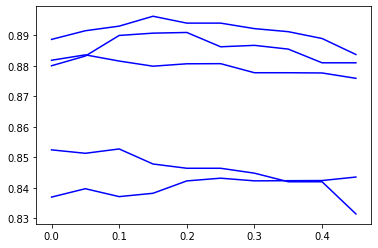

In [21]:
plt.plot(v_c,v_nbsendist[:,:],color='blue')